In [7]:
#basics
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


#preprocessing
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, PowerTransformer


#statistics
from scipy import stats
from scipy.stats import skew
from scipy.special import boxcox1p


#feature engineering
from sklearn.feature_selection import mutual_info_classif


#transformers and pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn import set_config


#algorithms
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression # Don't use it. (This is a multiclass classification problem)
from sklearn.svm import SVC


#model evaluation
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, log_loss
from sklearn.metrics import make_scorer, accuracy_score, log_loss

# Optuna and visualization tools
import optuna
from optuna.samplers import TPESampler
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice

# imbalanced learning
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline

random_state = 100

In [3]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.2 MB/s eta 0:00:00


In [4]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.0 MB/s eta 0:00:00


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!pip install optuna

In [6]:
!pip install xgboost
!pip install catboost
!pip install lightgbm

In [8]:
# Read the data
train = pd.read_csv(r"/content/drive/MyDrive/Sheet_1_9T_EnglishV1.csv")

# Create copies for different purposes
pipe_data = train.copy()  # Reserved for pipeline
train_df = train.copy()   # For preliminary analysis

# Initial data inspection
print("Dataset Shape:", train_df.shape)
print("\nFirst few rows:")
print(train_df.head())

# Quick info about the dataset
print("\nDataset Info:")
train_df.info()

# Check for missing values
print("\nMissing Values:")
print(train_df.isnull().sum())

Dataset Shape: (24, 5)

First few rows:
   Welding section (m)  Welding Rod Specification  welding speed(mm/min)  \
0                  2.5                        1.6                    450   
1                  2.5                        1.6                    450   
2                  2.5                        1.6                    450   
3                  2.5                        1.6                    450   
4                  2.5                        1.6                    500   

   current   voltage   
0       250        30  
1       260        31  
2       270        32  
3       270        32  
4       280        35  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Welding section (m)        24 non-null     float64
 1   Welding Rod Specification  24 non-null     float64
 2   welding speed

In [9]:
# Clean column names and create fresh copy
def clean_data_initial(df):
    # Create a fresh copy
    df_cleaned = df.copy()

    # Clean column names
    df_cleaned.columns = df_cleaned.columns.str.strip()

    # Clean specific column with newline
    if 'Gas flow rate\n(?/min)' in df_cleaned.columns:
        df_cleaned.rename(columns={'Gas flow rate\n(?/min)': 'Gas flow rate(?/min)'}, inplace=True)

    print("Original columns:", df.columns.tolist())
    print("\nCleaned columns:", df_cleaned.columns.tolist())
    return df_cleaned

# Apply cleaning to all dataframes
train_df = clean_data_initial(train)
pipe_data = clean_data_initial(train)

# Verify the cleaning
print("\nVerification - Unique values in key columns:")
for col in ['current', 'voltage', 'welding speed(mm/min)']:
    print(f"\n{col}:", train_df[col].unique())

Original columns: ['Welding section (m)', 'Welding Rod Specification', 'welding speed(mm/min)', 'current ', 'voltage ']

Cleaned columns: ['Welding section (m)', 'Welding Rod Specification', 'welding speed(mm/min)', 'current', 'voltage']
Original columns: ['Welding section (m)', 'Welding Rod Specification', 'welding speed(mm/min)', 'current ', 'voltage ']

Cleaned columns: ['Welding section (m)', 'Welding Rod Specification', 'welding speed(mm/min)', 'current', 'voltage']

Verification - Unique values in key columns:

current: [250 260 270 280 290 300 200 220]

voltage: [30 31 32 35 36 29 40]

welding speed(mm/min): [450 500 470]


In [10]:
def analyze_and_handle_imbalance(df):
    # Analyze distribution
    imbalance_stats = {}
    varying_features = [col for col in df.columns if len(df[col].unique()) > 1]

    for feature in varying_features:
        value_counts = df[feature].value_counts()
        ratio = value_counts.max() / value_counts.min()
        imbalance_stats[feature] = {
            'ratio': ratio,
            'distribution': value_counts.to_dict()
        }

    print("Imbalance Analysis:")
    for feature, stats in imbalance_stats.items():
        print(f"\n{feature}:")
        print(f"Max/Min ratio: {stats['ratio']:.2f}")
        print("Distribution:", stats['distribution'])

    return imbalance_stats

# Run imbalance analysis
imbalance_stats = analyze_and_handle_imbalance(train_df)

Imbalance Analysis:

welding speed(mm/min):
Max/Min ratio: 3.00
Distribution: {500: 12, 450: 8, 470: 4}

current:
Max/Min ratio: 7.00
Distribution: {250: 7, 270: 5, 260: 4, 220: 3, 290: 2, 280: 1, 300: 1, 200: 1}

voltage:
Max/Min ratio: 6.00
Distribution: {32: 6, 31: 5, 36: 4, 30: 3, 35: 3, 40: 2, 29: 1}


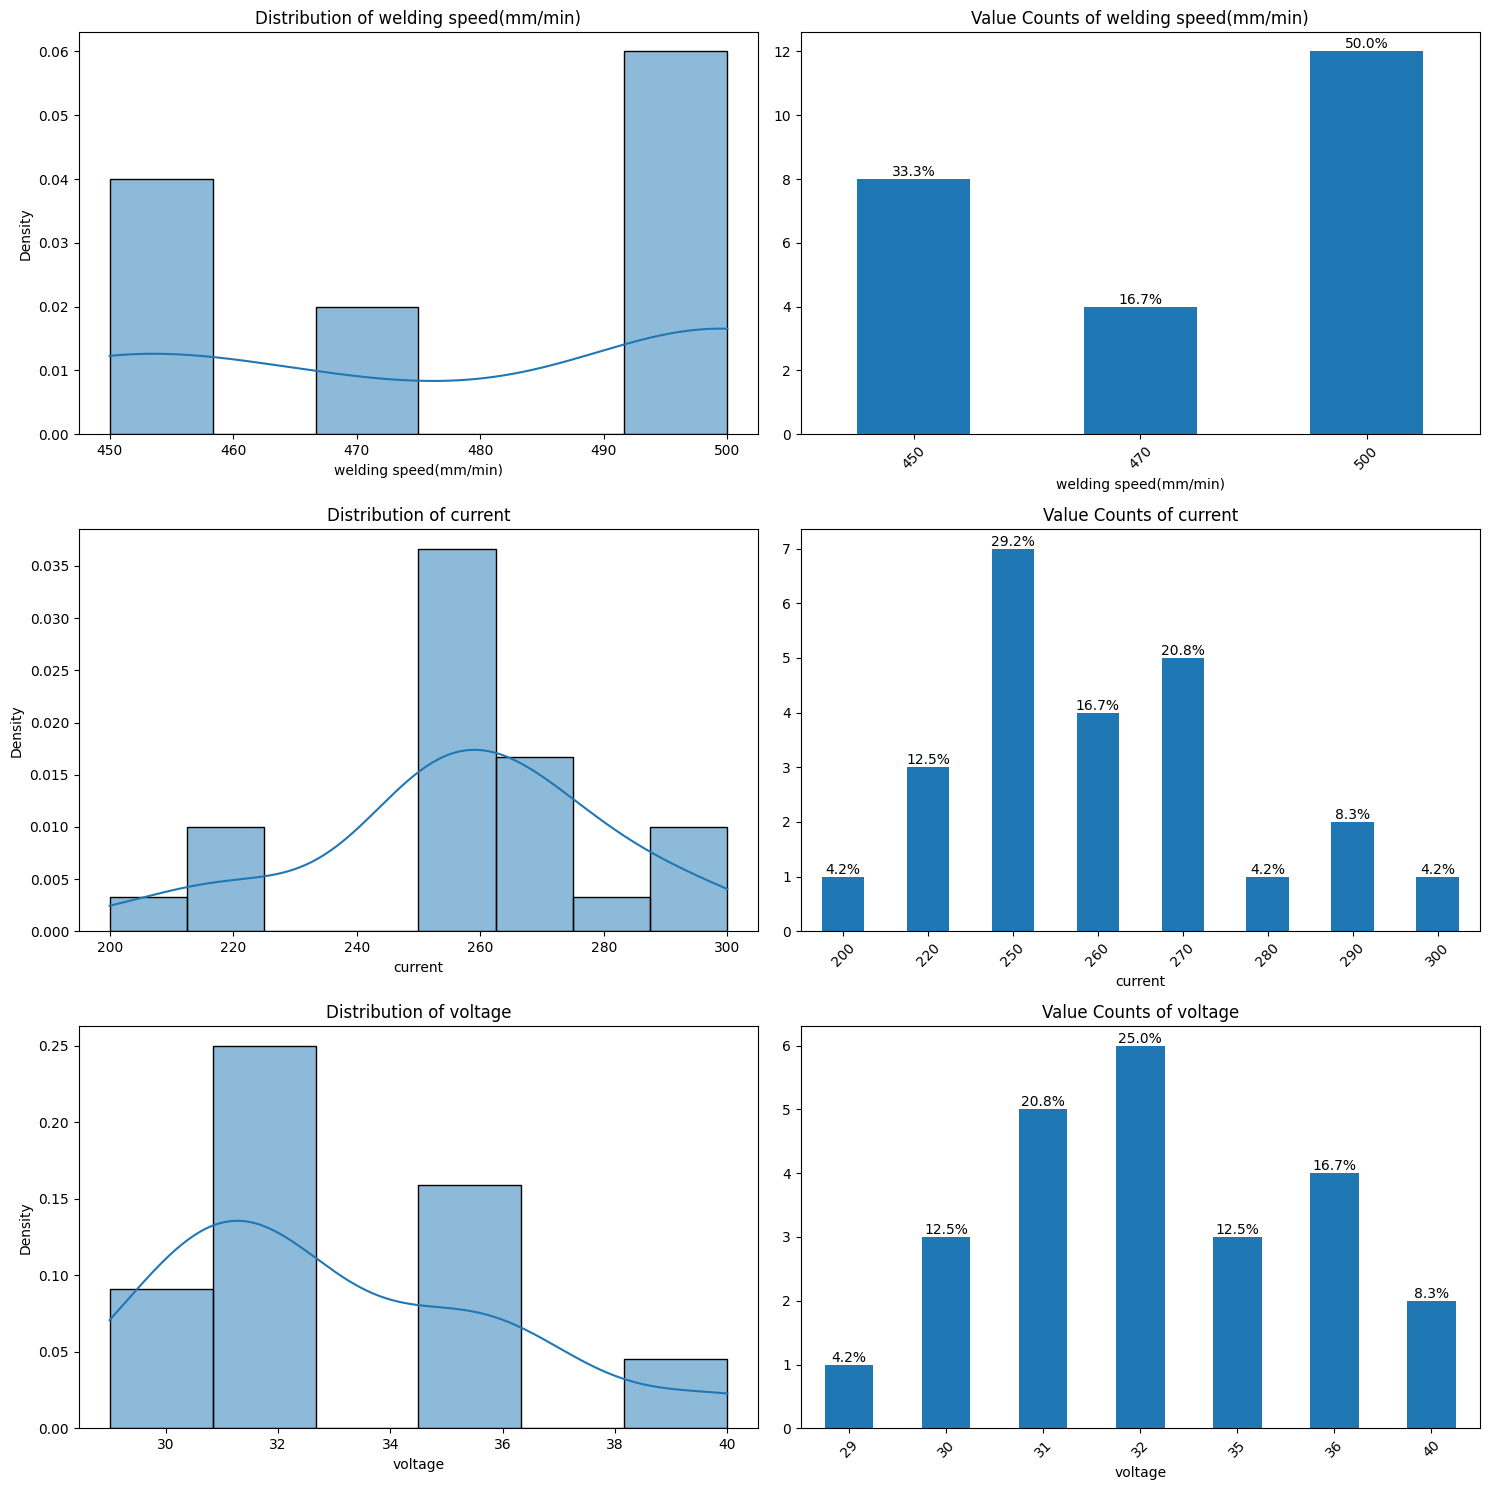


Numerical Summary of Distributions:

welding speed(mm/min):
count     24.00
mean     478.33
std       23.16
min      450.00
25%      450.00
50%      485.00
75%      500.00
max      500.00
Name: welding speed(mm/min), dtype: float64

current:
count     24.00
mean     256.67
std       23.90
min      200.00
25%      250.00
50%      260.00
75%      270.00
max      300.00
Name: current, dtype: float64

voltage:
count    24.00
mean     33.12
std       3.05
min      29.00
25%      31.00
50%      32.00
75%      35.25
max      40.00
Name: voltage, dtype: float64


In [11]:
def plot_improved_distributions(df):
    # Get varying features
    varying_features = [col for col in df.columns if len(df[col].unique()) > 1]

    # Number of features
    n_features = len(varying_features)

    # Create subplots
    fig, axes = plt.subplots(n_features, 2, figsize=(15, 5*n_features))

    # Handle single feature case
    if n_features == 1:
        axes = axes.reshape(1, -1)

    for idx, feature in enumerate(varying_features):
        # Distribution plot with KDE
        sns.histplot(data=df, x=feature, kde=True, stat='density', ax=axes[idx, 0])
        axes[idx, 0].set_title(f'Distribution of {feature}')

        # Value counts with percentages
        value_counts = df[feature].value_counts().sort_index()
        percentages = (value_counts / len(df) * 100).round(1)
        value_counts.plot(kind='bar', ax=axes[idx, 1])

        # Add percentage labels
        for i, (value, percentage) in enumerate(zip(value_counts, percentages)):
            axes[idx, 1].text(i, value, f'{percentage}%',
                            ha='center', va='bottom')

        axes[idx, 1].set_title(f'Value Counts of {feature}')
        axes[idx, 1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    # Print numerical summary
    print("\nNumerical Summary of Distributions:")
    for feature in varying_features:
        print(f"\n{feature}:")
        print(df[feature].describe().round(2))

# Plot improved distributions
plot_improved_distributions(train_df)

In [12]:
# First run the cleaning
train_df = clean_data_initial(train)

Original columns: ['Welding section (m)', 'Welding Rod Specification', 'welding speed(mm/min)', 'current ', 'voltage ']

Cleaned columns: ['Welding section (m)', 'Welding Rod Specification', 'welding speed(mm/min)', 'current', 'voltage']


In [13]:
# Rerun Cell 2 with cleaned data
print("Statistical Summary:")
print(train_df.describe().round(2))

Statistical Summary:
       Welding section (m)  Welding Rod Specification  welding speed(mm/min)  \
count                 24.0                       24.0                  24.00   
mean                   2.5                        1.6                 478.33   
std                    0.0                        0.0                  23.16   
min                    2.5                        1.6                 450.00   
25%                    2.5                        1.6                 450.00   
50%                    2.5                        1.6                 485.00   
75%                    2.5                        1.6                 500.00   
max                    2.5                        1.6                 500.00   

       current  voltage  
count    24.00    24.00  
mean    256.67    33.12  
std      23.90     3.05  
min     200.00    29.00  
25%     250.00    31.00  
50%     260.00    32.00  
75%     270.00    35.25  
max     300.00    40.00  


In [21]:
# Update validation ranges with clean column names
expected_ranges = {
    'Welding section (m)': (0, 10),
    'Welding Rod Specification': (0, 5),
    'welding speed(mm/min)': (0, 1000),
    'current': (0, 500),    # No space
    'voltage': (0, 50),     # No space
}

In [22]:
# Rerun feature analysis with cleaned data
feature_analysis = analyze_feature_variation(train_df)

NameError: name 'analyze_feature_variation' is not defined

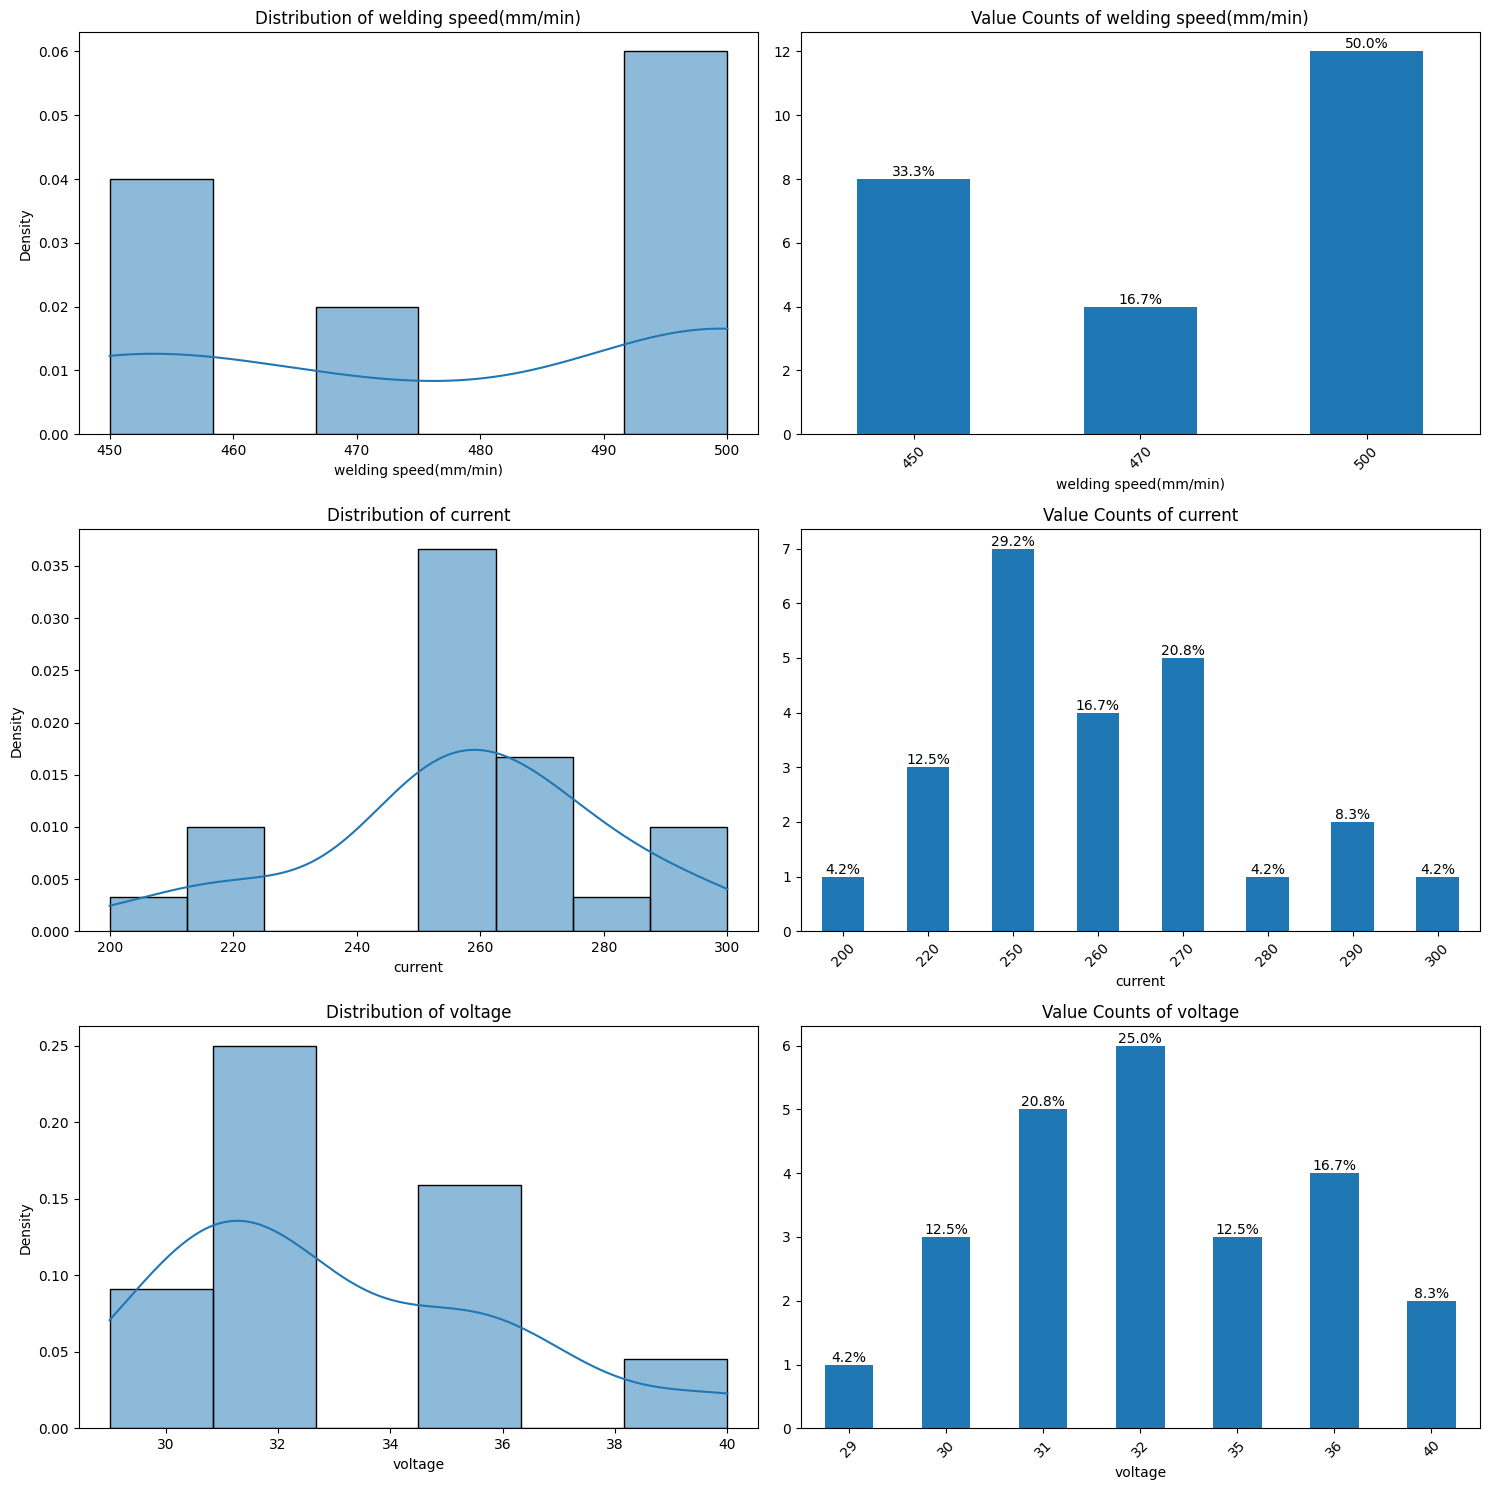


Numerical Summary of Distributions:

welding speed(mm/min):
count     24.00
mean     478.33
std       23.16
min      450.00
25%      450.00
50%      485.00
75%      500.00
max      500.00
Name: welding speed(mm/min), dtype: float64

current:
count     24.00
mean     256.67
std       23.90
min      200.00
25%      250.00
50%      260.00
75%      270.00
max      300.00
Name: current, dtype: float64

voltage:
count    24.00
mean     33.12
std       3.05
min      29.00
25%      31.00
50%      32.00
75%      35.25
max      40.00
Name: voltage, dtype: float64


In [16]:
# Run improved distribution plots
plot_improved_distributions(train_df)

In [17]:
# Save cleaned versions
train_df_clean = train_df.copy()
pipe_data_clean = pipe_data.copy()

In [18]:
# Summary statistics of numerical columns
print("Statistical Summary:")
print(train_df.describe().round(2))

# Check unique values in each column
print("\nUnique Values per Column:")
for column in train_df.columns:
    unique_vals = train_df[column].nunique()
    print(f"{column}: {unique_vals} unique values")

Statistical Summary:
       Welding section (m)  Welding Rod Specification  welding speed(mm/min)  \
count                 24.0                       24.0                  24.00   
mean                   2.5                        1.6                 478.33   
std                    0.0                        0.0                  23.16   
min                    2.5                        1.6                 450.00   
25%                    2.5                        1.6                 450.00   
50%                    2.5                        1.6                 485.00   
75%                    2.5                        1.6                 500.00   
max                    2.5                        1.6                 500.00   

       current  voltage  
count    24.00    24.00  
mean    256.67    33.12  
std      23.90     3.05  
min     200.00    29.00  
25%     250.00    31.00  
50%     260.00    32.00  
75%     270.00    35.25  
max     300.00    40.00  

Unique Values per Colum

In [19]:
# Print the exact column names to see what we're working with
print("Column names:", list(train_df.columns))

Column names: ['Welding section (m)', 'Welding Rod Specification', 'welding speed(mm/min)', 'current', 'voltage']



Engineered Features Created:

power:
count       24.00
mean      8544.58
std       1413.10
min       5800.00
25%       7500.00
50%       8480.00
75%       9470.00
max      10800.00
Name: power, dtype: float64

speed_power_ratio:
count    24.00
mean      0.06
std       0.01
min       0.04
25%       0.05
50%       0.06
75%       0.06
max       0.09
Name: speed_power_ratio, dtype: float64

heat_input:
count    24.00
mean     17.92
std       3.12
min      11.60
25%      16.23
50%      17.60
75%      19.90
max      24.00
Name: heat_input, dtype: float64

heat_density:
count    24.00
mean      7.17
std       1.25
min       4.64
25%       6.49
50%       7.04
75%       7.96
max       9.60
Name: heat_density, dtype: float64

power_density:
count      24.00
mean     3417.83
std       565.24
min      2320.00
25%      3000.00
50%      3392.00
75%      3788.00
max      4320.00
Name: power_density, dtype: float64

current_voltage_ratio:
count    24.00
mean      7.77
std       0.62
min       6.75
25

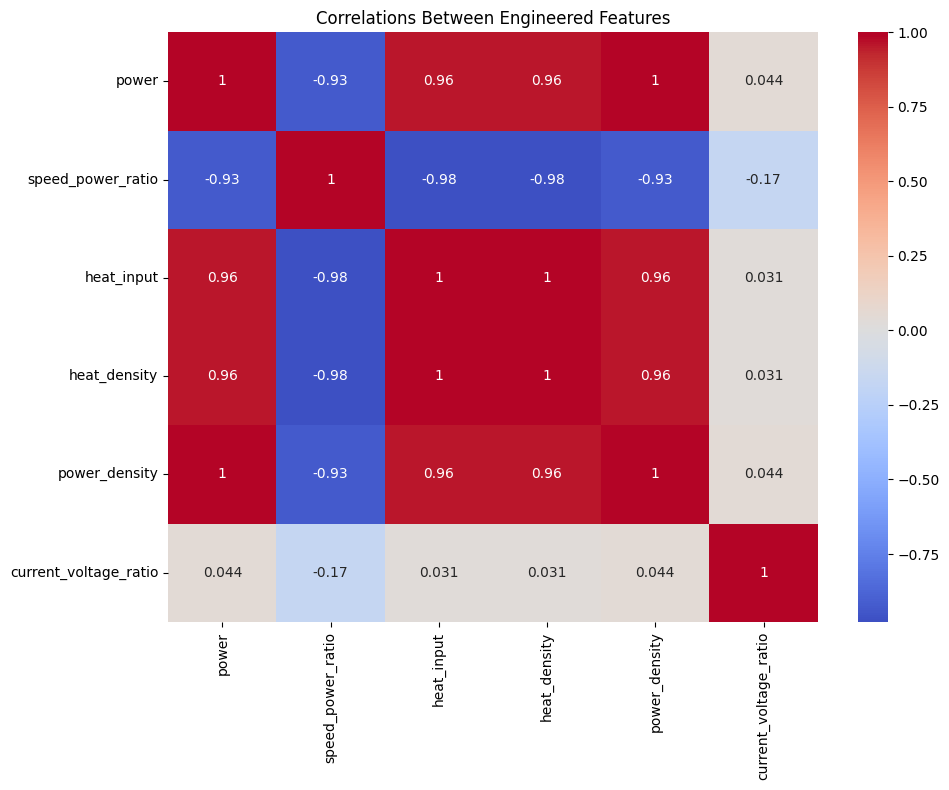

In [23]:
def engineer_welding_features(df):
    # Create copy to avoid modifying original
    df_engineered = df.copy()

    try:
        # 1. Power-related features
        df_engineered['power'] = df['current'] * df['voltage']

        # 2. Heat input features
        df_engineered['heat_input'] = df_engineered['power'] / df['welding speed(mm/min)']

        # 3. Efficiency ratios
        df_engineered['speed_power_ratio'] = df['welding speed(mm/min)'] / df_engineered['power']
        df_engineered['current_voltage_ratio'] = df['current'] / df['voltage']

        # 4. Area-based features
        df_engineered['power_density'] = df_engineered['power'] / df['Welding section (m)']
        df_engineered['heat_density'] = df_engineered['heat_input'] / df['Welding section (m)']

        # 5. Print summary of new features
        print("\nEngineered Features Created:")
        new_features = set(df_engineered.columns) - set(df.columns)
        for feature in new_features:
            print(f"\n{feature}:")
            print(df_engineered[feature].describe().round(2))

        return df_engineered

    except Exception as e:
        print(f"Error in feature engineering: {str(e)}")
        return None

# Apply feature engineering
train_df_engineered = engineer_welding_features(train_df)

# Show correlations between new features
if train_df_engineered is not None:
    new_features = set(train_df_engineered.columns) - set(train_df.columns)
    print("\nCorrelations between engineered features:")
    correlation_matrix = train_df_engineered[list(new_features)].corr()
    print(correlation_matrix.round(3))

    # Visualize correlations
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Correlations Between Engineered Features')
    plt.tight_layout()
    plt.show()

In [25]:
# Validate data ranges and identify potential issues
def validate_data_ranges(df):
    validation_results = {}

    # First, let's print actual column names to debug
    print("Actual columns in dataframe:", df.columns.tolist())

    # Expected ranges for each parameter - using exact column names from your dataframe
    expected_ranges = {
        'Welding section (m)': (0, 10),
        'Welding Rod Specification': (0, 5),
        'welding speed(mm/min)': (0, 1000),
        'current': (0, 500),  # Check if there's a space in column name
        'voltage': (0, 50),
    }

    # Validate each column exists before checking ranges
    for column, (min_val, max_val) in expected_ranges.items():
        if column in df.columns:
            column_data = {
                'min': df[column].min(),
                'max': df[column].max(),
                'is_within_range': (df[column].min() >= min_val) and
                                 (df[column].max() <= max_val)
            }
            validation_results[column] = column_data
        else:
            print(f"Warning: Column '{column}' not found in dataframe")

    return validation_results

# Add error handling
try:
    validation_results = validate_data_ranges(train_df)
    print("\nData Validation Results:")
    for column, results in validation_results.items():
        print(f"\n{column}:")
        print(f"Range: {results['min']} to {results['max']}")
        print(f"Within expected range: {results['is_within_range']}")
except Exception as e:
    print(f"Error occurred: {str(e)}")
    print("\nLet's check the actual data structure:")
    print("\nColumns in dataframe:")
    print(train_df.columns.tolist())
    print("\nSample of data:")
    print(train_df.head())

Actual columns in dataframe: ['Welding section (m)', 'Welding Rod Specification', 'welding speed(mm/min)', 'current', 'voltage']

Data Validation Results:

Welding section (m):
Range: 2.5 to 2.5
Within expected range: True

Welding Rod Specification:
Range: 1.6 to 1.6
Within expected range: True

welding speed(mm/min):
Range: 450 to 500
Within expected range: True

current:
Range: 200 to 300
Within expected range: True

voltage:
Range: 29 to 40
Within expected range: True


In [26]:
def analyze_feature_variation(df):
    feature_analysis = {
        'constant_features': [],
        'varying_features': [],
        'variation_details': {}
    }

    for column in df.columns:
        unique_values = df[column].unique()
        if len(unique_values) == 1:
            feature_analysis['constant_features'].append(column)
        else:
            feature_analysis['varying_features'].append(column)

        feature_analysis['variation_details'][column] = {
            'unique_values': len(unique_values),
            'values': unique_values
        }

    return feature_analysis

feature_analysis = analyze_feature_variation(train_df)
print("\nConstant Features:", feature_analysis['constant_features'])
print("\nVarying Features:", feature_analysis['varying_features'])
print("\nDetailed Analysis:")
for feature, details in feature_analysis['variation_details'].items():
    print(f"\n{feature}:")
    print(f"Number of unique values: {details['unique_values']}")
    print(f"Values: {details['values']}")


Constant Features: ['Welding section (m)', 'Welding Rod Specification']

Varying Features: ['welding speed(mm/min)', 'current', 'voltage']

Detailed Analysis:

Welding section (m):
Number of unique values: 1
Values: [2.5]

Welding Rod Specification:
Number of unique values: 1
Values: [1.6]

welding speed(mm/min):
Number of unique values: 3
Values: [450 500 470]

current:
Number of unique values: 8
Values: [250 260 270 280 290 300 200 220]

voltage:
Number of unique values: 7
Values: [30 31 32 35 36 29 40]


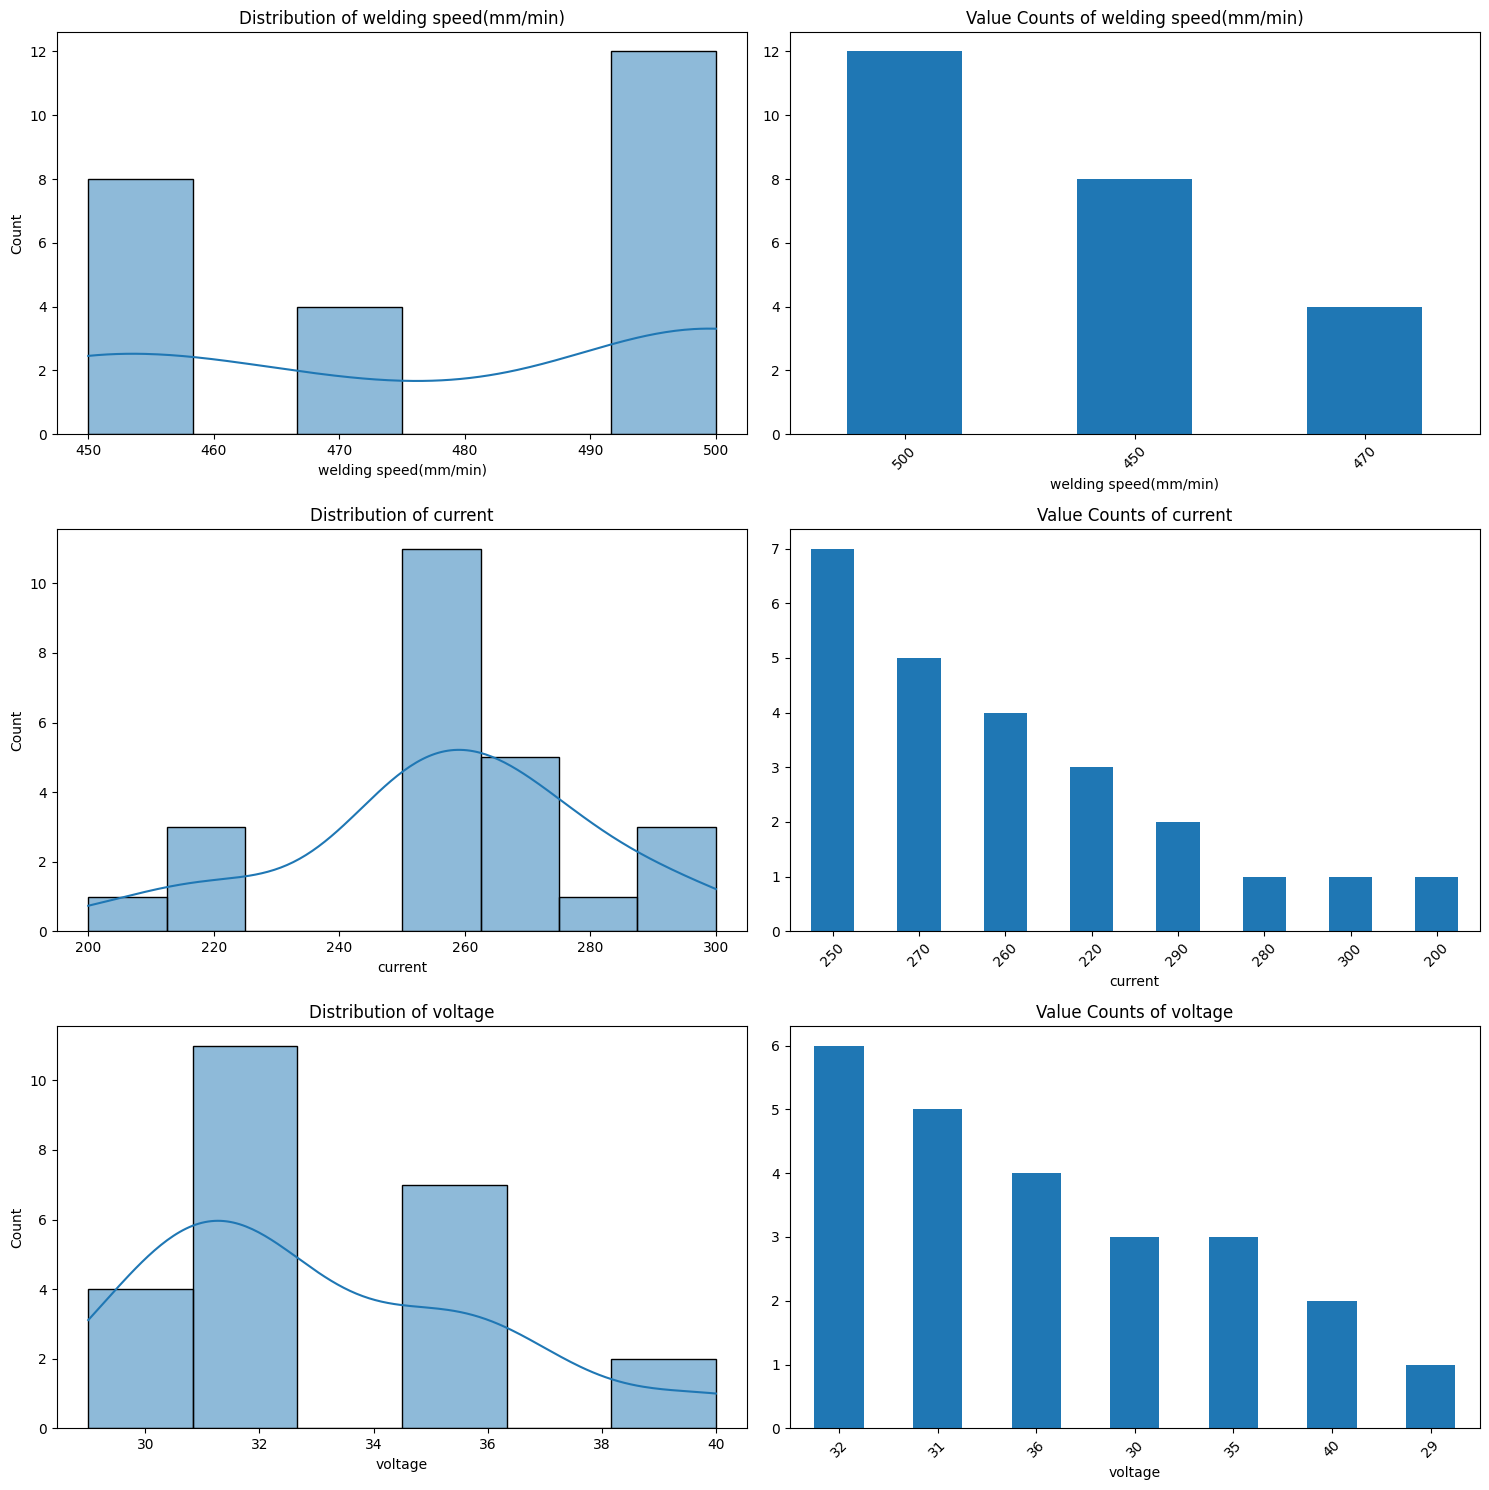

In [27]:
def plot_initial_distributions(df):
    varying_features = [col for col in df.columns
                       if len(df[col].unique()) > 1]

    plt.figure(figsize=(15, 5*len(varying_features)))
    for idx, feature in enumerate(varying_features, 1):
        plt.subplot(len(varying_features), 2, idx*2-1)
        sns.histplot(data=df, x=feature, kde=True)
        plt.title(f'Distribution of {feature}')

        plt.subplot(len(varying_features), 2, idx*2)
        df[feature].value_counts().plot(kind='bar')
        plt.title(f'Value Counts of {feature}')
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

plot_initial_distributions(train_df)

In [28]:
#numerical feature descriptive statistics
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Welding section (m),24.0,2.500000,0.000000e+00,2.5,2.5,2.5,2.50,2.5
Welding Rod Specification,24.0,1.600000,4.536406e-16,1.6,1.6,1.6,1.60,1.6
welding speed(mm/min),24.0,478.333333,2.315668e+01,450.0,450.0,485.0,500.00,500.0
current,24.0,256.666667,2.389591e+01,200.0,250.0,260.0,270.00,300.0
voltage,24.0,33.125000,3.054754e+00,29.0,31.0,32.0,35.25,40.0


In [29]:
train_df.nunique().sort_values()

,0
Welding section (m),1
Welding Rod Specification,1
welding speed(mm/min),3
voltage,7
current,8


In [30]:
# Bookkeeping for engineered dataset
feature_list = [feature for feature in train_df_engineered.columns]  # All columns are features

# No categorical features in this dataset
categorical_features = []

# All features are numerical
numerical_features = feature_list

# Split features based on unique values
discrete_features = []
continuous_features = []

# Categorize features based on number of unique values
for feature in numerical_features:
    n_unique = len(train_df_engineered[feature].unique())
    if n_unique <= 3:  # Threshold for discrete vs continuous
        discrete_features.append(feature)
    else:
        continuous_features.append(feature)

# Print feature counts
print("\nFeature Counts:")
print(f"Total features: {len(feature_list)}")
print(f"Discrete features: {len(discrete_features)}")
print(f"Continuous features: {len(continuous_features)}")

# Verification
assert set(feature_list) == set(numerical_features)  # All features are numerical
assert set(numerical_features) == set(discrete_features + continuous_features)  # All numericals are either discrete or continuous

# Print feature details
print("\nFeature Categories:")
print("\nDiscrete Features:")
for feat in discrete_features:
    print(f"- {feat}: {len(train_df_engineered[feat].unique())} unique values")

print("\nContinuous Features:")
for feat in continuous_features:
    print(f"- {feat}: {len(train_df_engineered[feat].unique())} unique values")

# Print summary statistics for continuous features
print("\nSummary Statistics for Continuous Features:")
print(train_df_engineered[continuous_features].describe().round(2))


Feature Counts:
Total features: 11
Discrete features: 3
Continuous features: 8

Feature Categories:

Discrete Features:
- Welding section (m): 1 unique values
- Welding Rod Specification: 1 unique values
- welding speed(mm/min): 3 unique values

Continuous Features:
- current: 8 unique values
- voltage: 7 unique values
- power: 15 unique values
- heat_input: 19 unique values
- speed_power_ratio: 19 unique values
- current_voltage_ratio: 15 unique values
- power_density: 15 unique values
- heat_density: 19 unique values

Summary Statistics for Continuous Features:
       current  voltage     power  heat_input  speed_power_ratio  \
count    24.00    24.00     24.00       24.00              24.00   
mean    256.67    33.12   8544.58       17.92               0.06   
std      23.90     3.05   1413.10        3.12               0.01   
min     200.00    29.00   5800.00       11.60               0.04   
25%     250.00    31.00   7500.00       16.23               0.05   
50%     260.00    32.

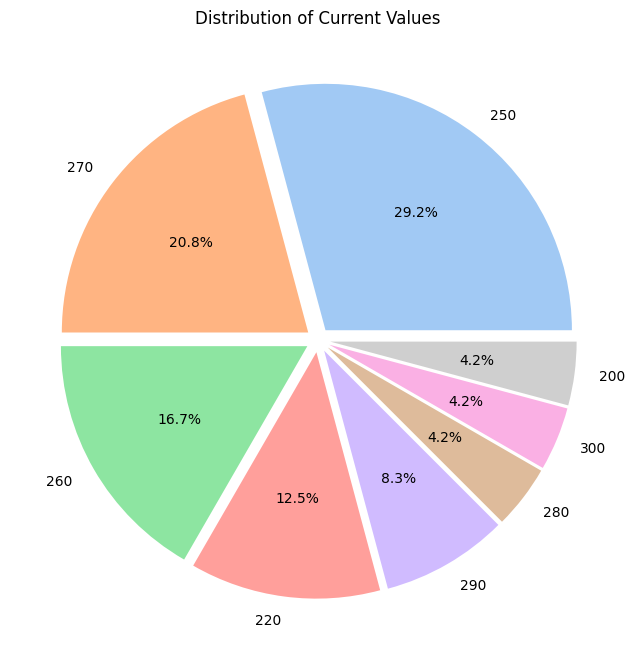

In [31]:
# Distribution of Current Values
plt.figure(figsize=(8, 8))
palette_color = sns.color_palette('pastel')

# Get current value counts
current_counts = train_df_engineered['current'].value_counts()

# Create pie chart
plt.pie(current_counts,
        labels=current_counts.index,  # Current values as labels
        colors=palette_color,
        explode=[0.05] * len(current_counts),  # Small separation for all slices
        autopct="%1.1f%%")  # Show percentages

plt.title('Distribution of Current Values')
plt.show()

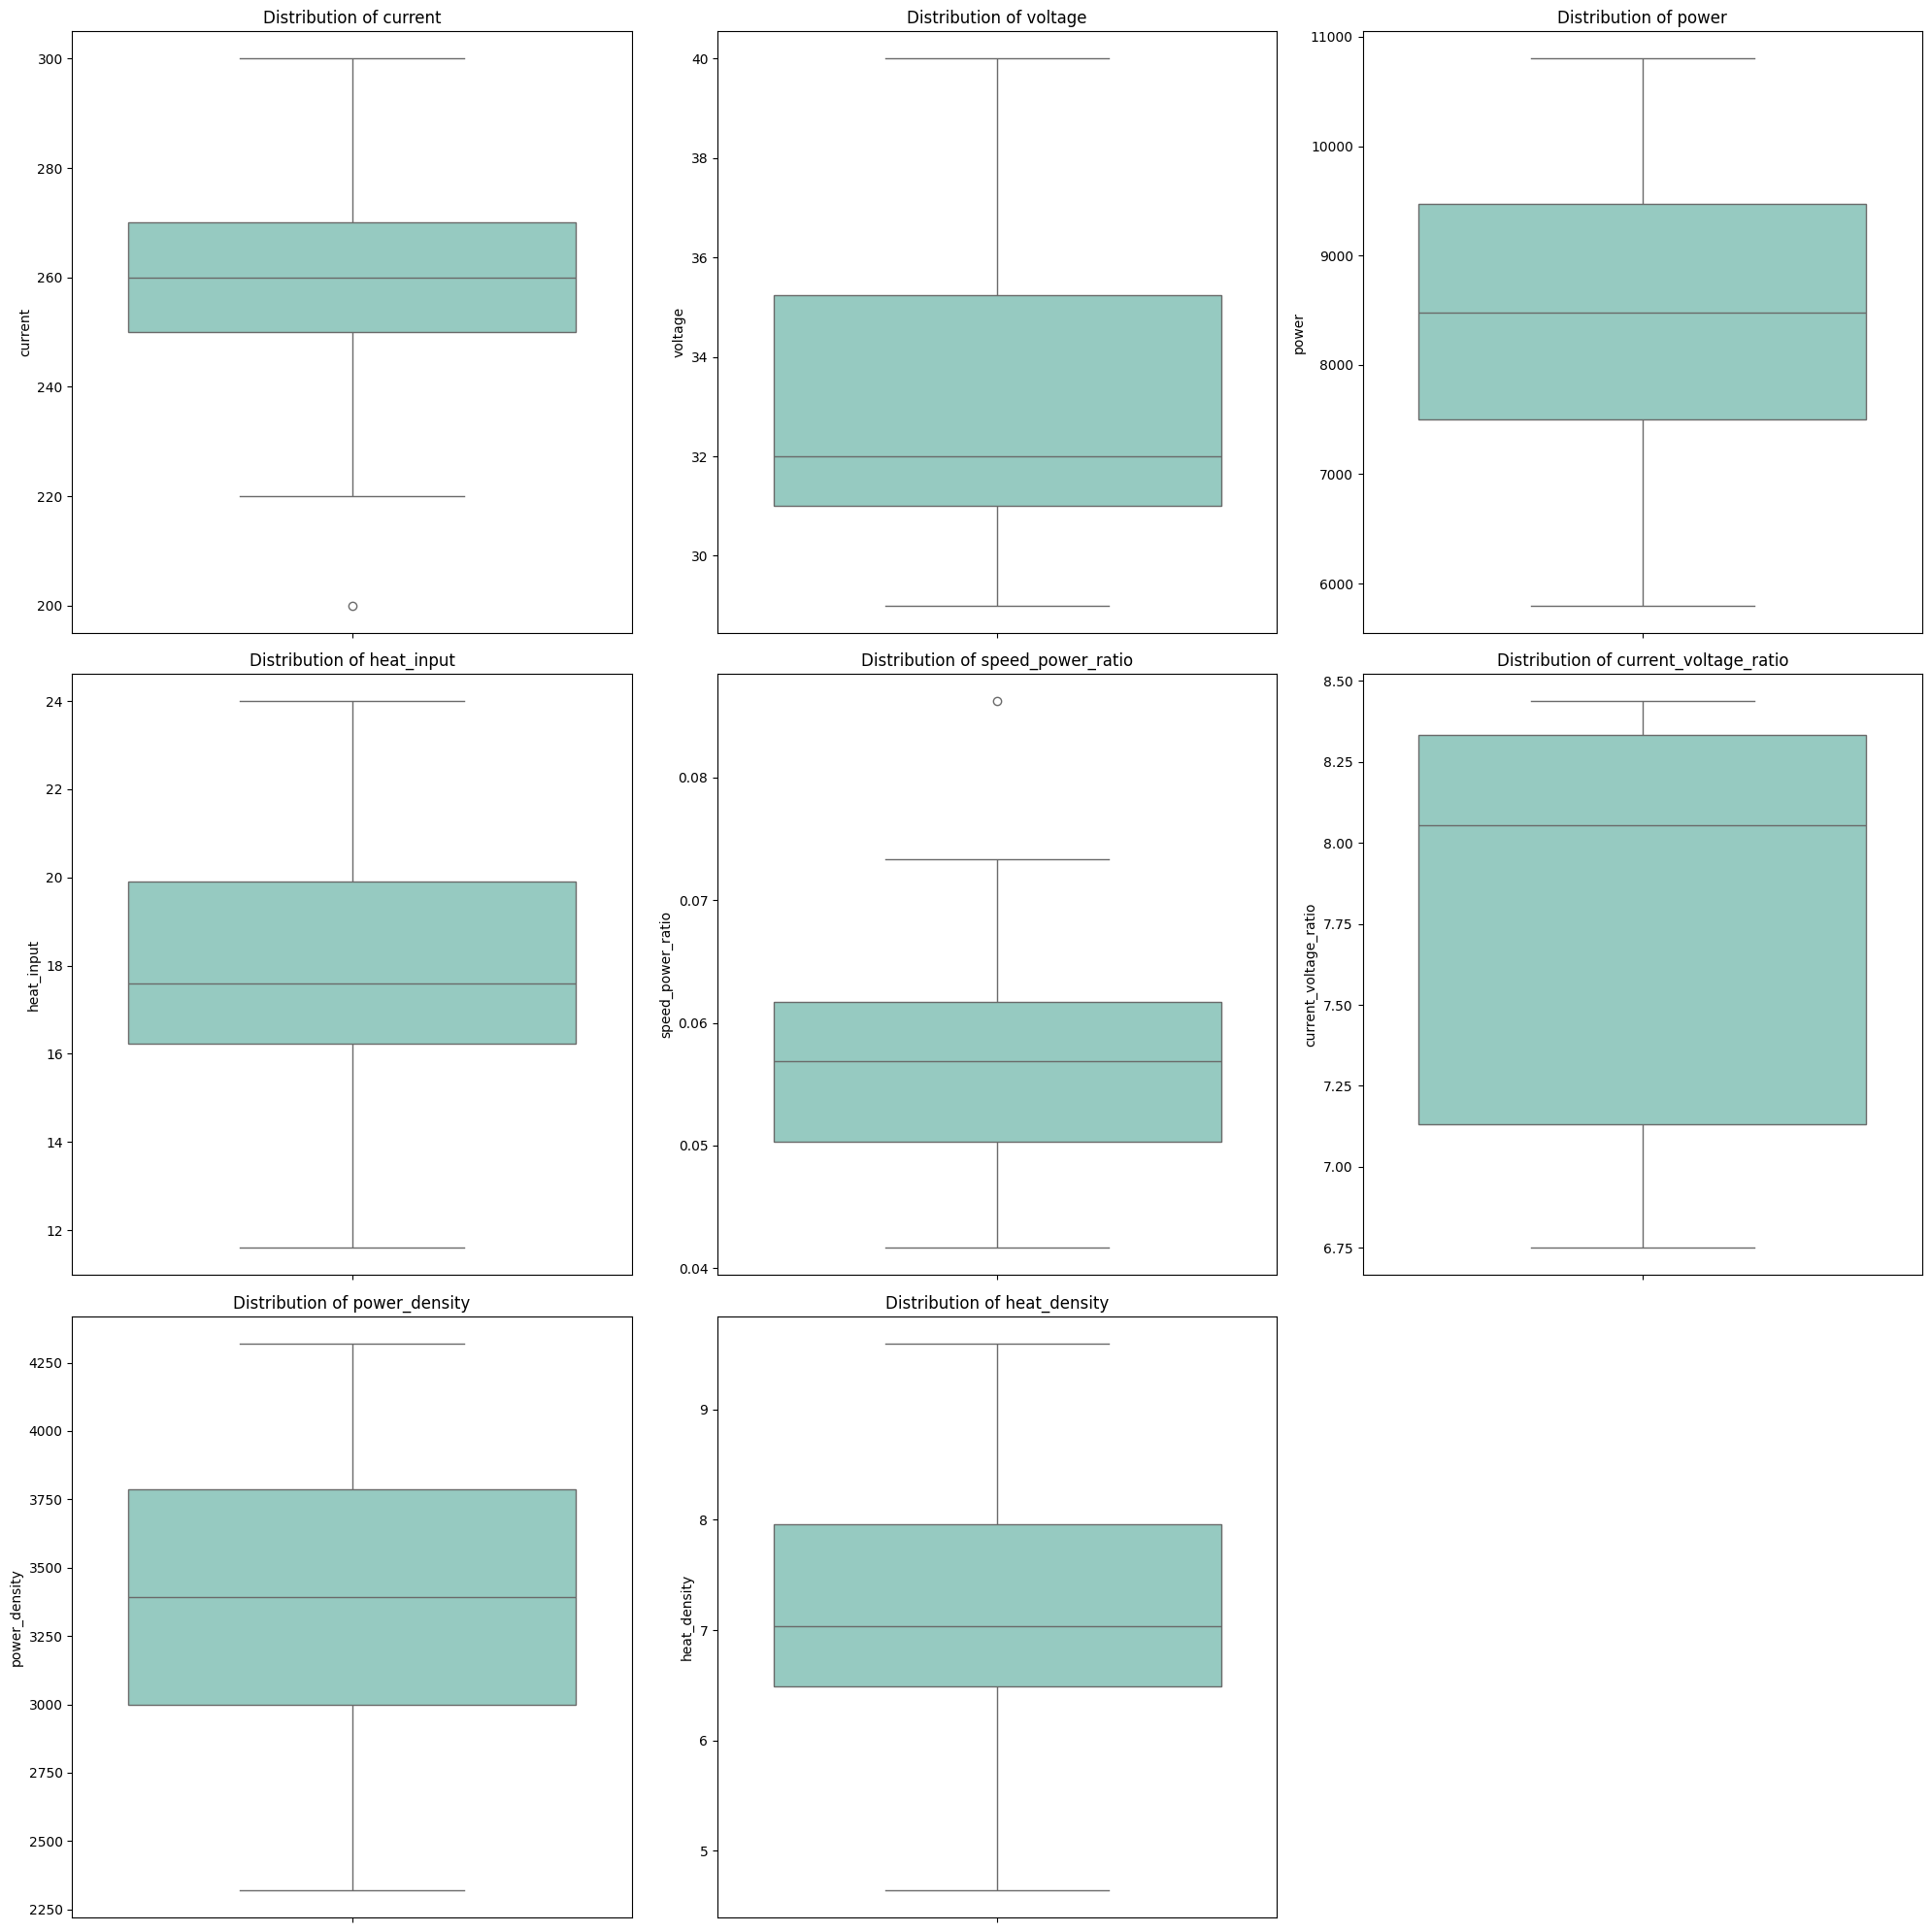

In [32]:
# Create boxplots for continuous features
fig, ax = plt.subplots(3, 3, figsize=(20, 20))

# Create boxplots for each continuous feature
for var, subplot in zip(continuous_features, ax.flatten()):
    sns.boxplot(data=train_df_engineered, y=var, ax=subplot, palette='Set3')
    subplot.set_title(f'Distribution of {var}')
    subplot.set_ylabel(var)

# Remove any empty subplots if number of features < 9
if len(continuous_features) < 9:
    for i in range(len(continuous_features), 9):
        fig.delaxes(ax.flatten()[i])

plt.tight_layout()
plt.show()

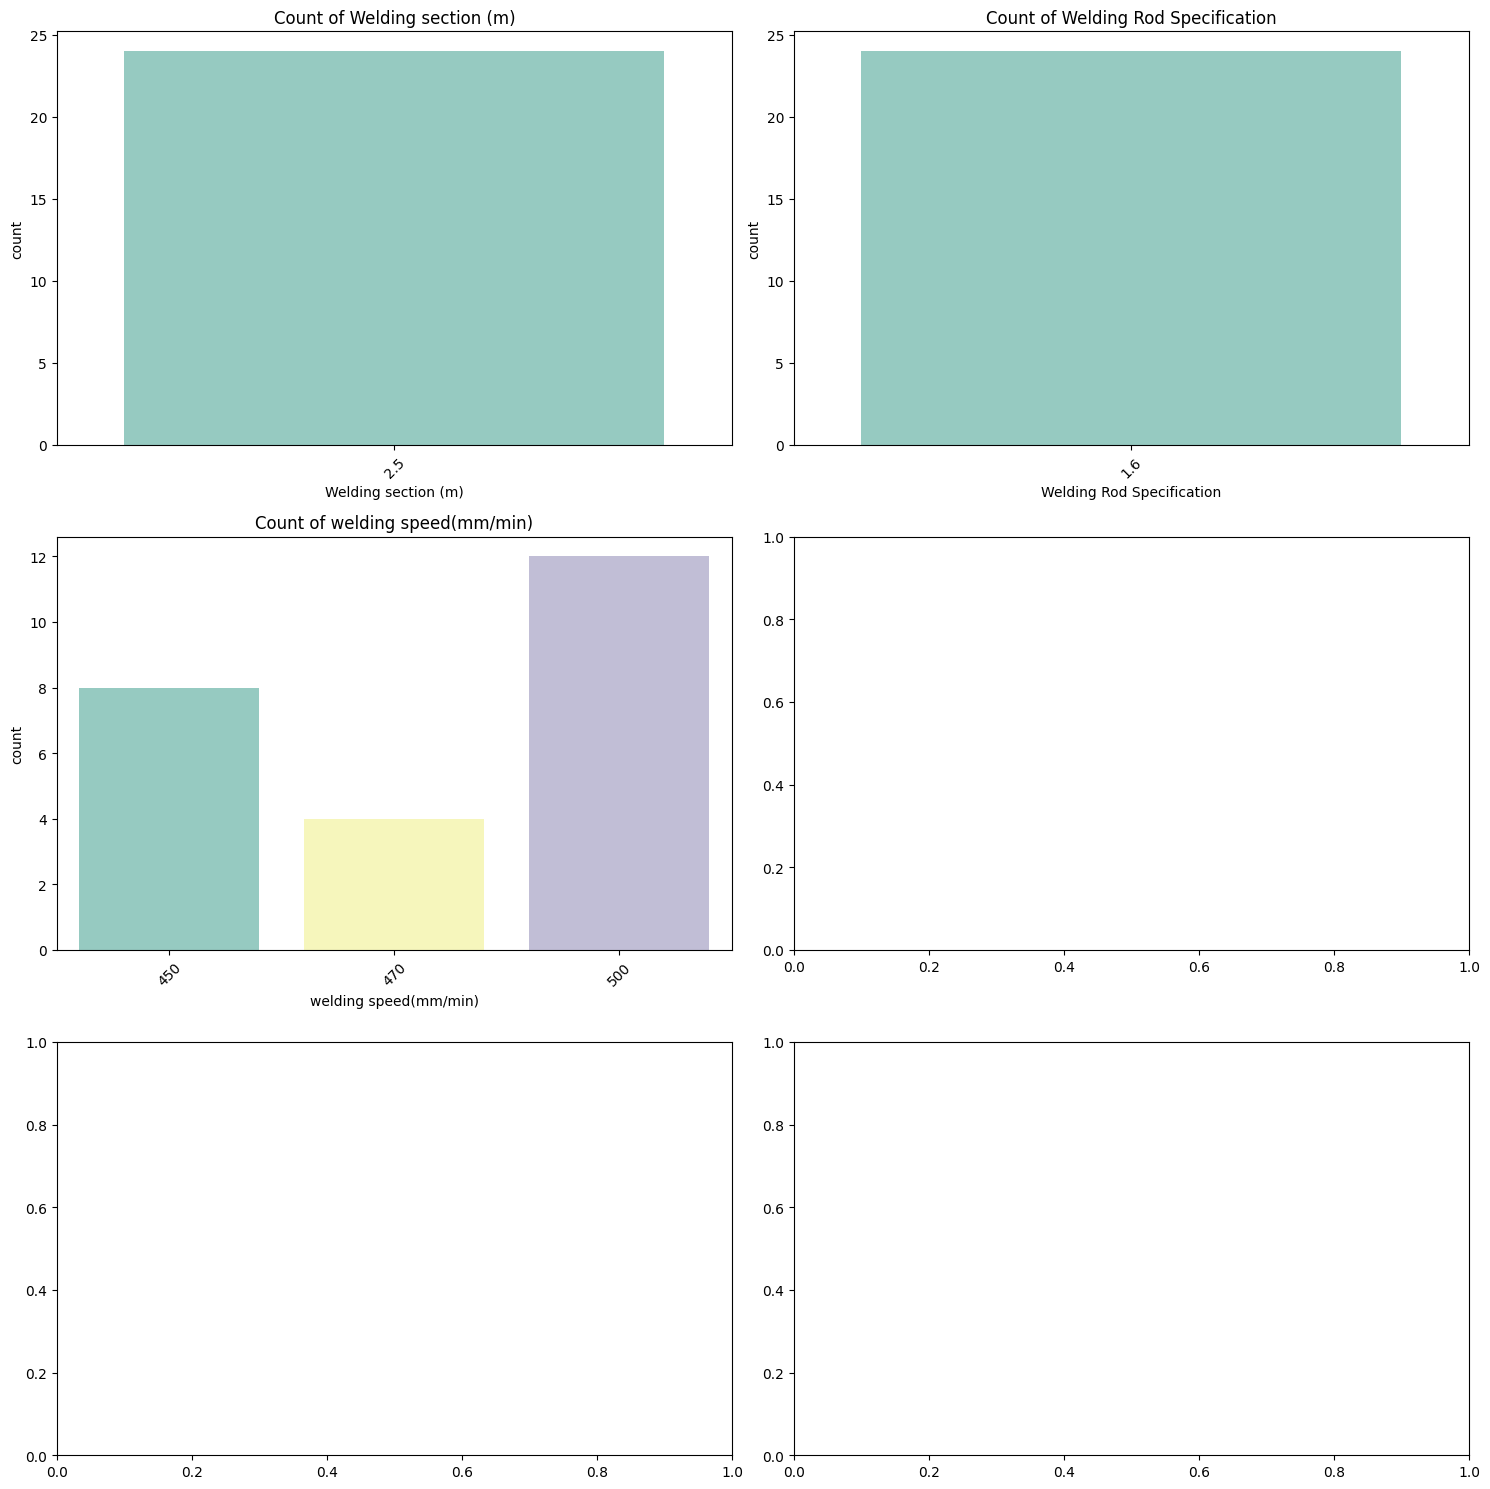

In [33]:
fig, ax = plt.subplots(3, 2, figsize=(15, 15))  # Modified for 5 discrete features
for var, subplot in zip(discrete_features, ax.flatten()):
    sns.countplot(data=train_df, x=var, ax=subplot, palette='Set3')
    subplot.set_title(f'Count of {var}')
    subplot.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()# Set 'current' as target variable (you can change this to any column you want to predict)
y = train_df['current']

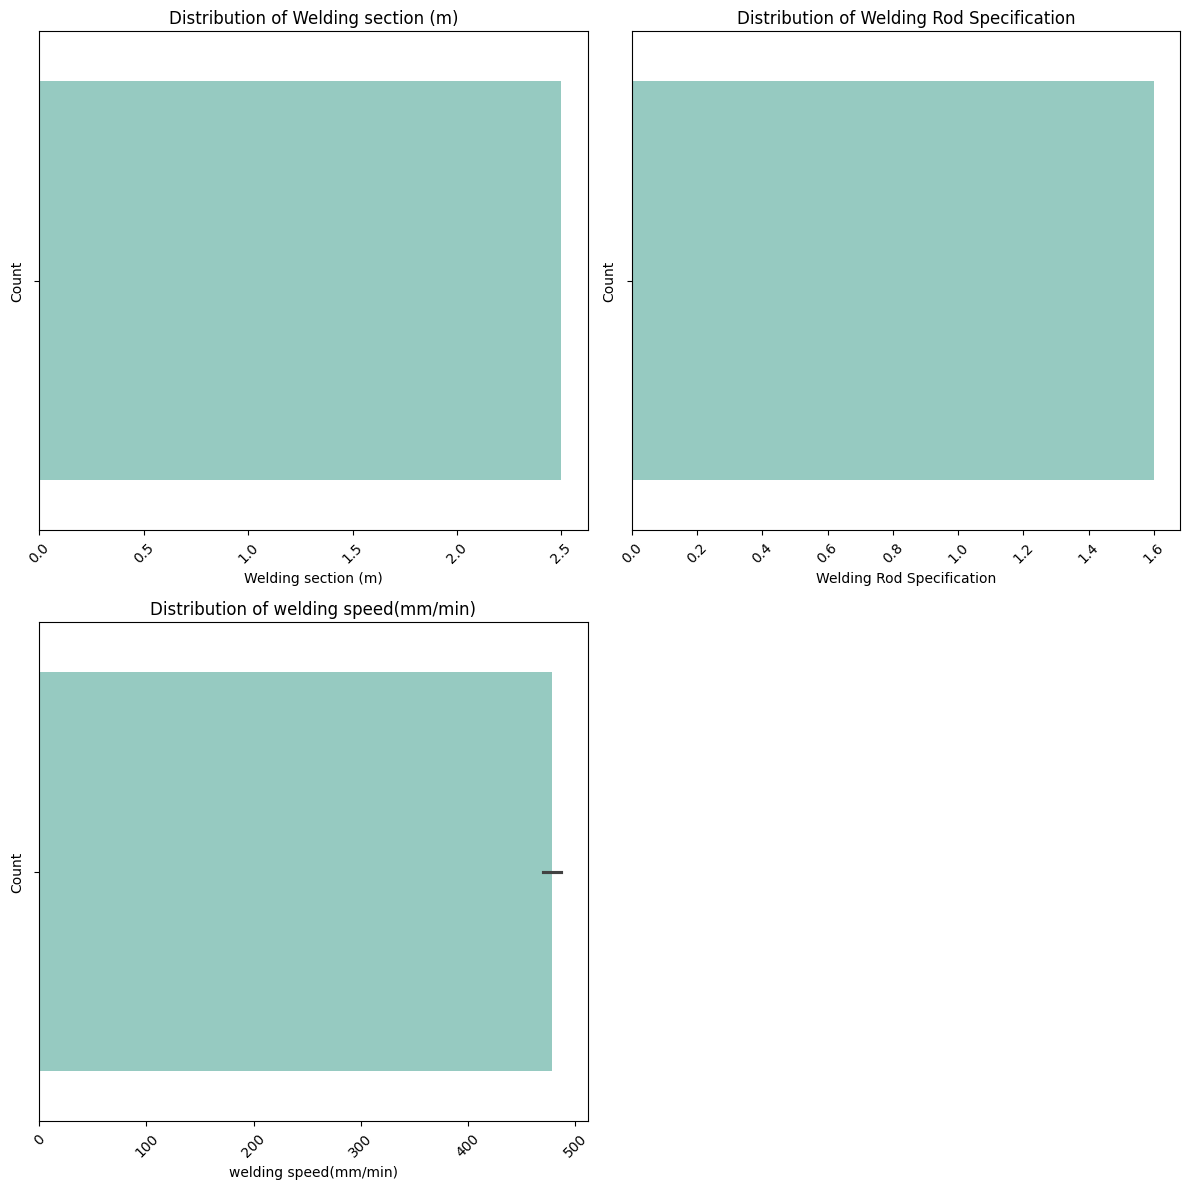

In [34]:
# Create barplots for categorical and discrete features
fig, ax = plt.subplots(2, 2, figsize=(12, 12))

# Combine categorical and discrete features
plot_features = categorical_features + discrete_features
# Remember from earlier:
# categorical_features = ['Welding Rod Specification']
# discrete_features = ['welding speed(mm/min)', 'Gas flow rate(?/min)', 'torch height(mm)']

# Create barplots
for var, subplot in zip(plot_features, ax.flatten()):
    sns.barplot(x=var, data=train_df_engineered, ax=subplot, palette='Set3')
    subplot.set_title(f'Distribution of {var}')
    subplot.set_ylabel('Count')
    # Rotate x-labels if needed
    subplot.tick_params(axis='x', rotation=45)

# Remove empty subplots if any
if len(plot_features) < 4:
    for i in range(len(plot_features), 4):
        fig.delaxes(ax.flatten()[i])

plt.tight_layout()
plt.show()

In [35]:
from sklearn.feature_selection import mutual_info_regression
import numpy as np

# Use one of your continuous variables as target for demonstration
# For example, let's use 'current' as target
y = train_df_engineered['current']

# Prepare numerical features (excluding the target)
mutual_df = train_df_engineered[continuous_features].drop('current', axis=1)

# Calculate mutual information
mutual_info = mutual_info_regression(mutual_df, y, random_state=42)

# Create series with feature names
mutual_info = pd.Series(mutual_info)
mutual_info.index = mutual_df.columns

# Display results with gradient coloring
pd.DataFrame(mutual_info.sort_values(ascending=False),
            columns=["MI_score"]).style.background_gradient("cool")

,MI_score
power_density,0.799124
power,0.790791
heat_input,0.604338
heat_density,0.604338
speed_power_ratio,0.529645
voltage,0.379641
current_voltage_ratio,0.104318


In [36]:
# Use discrete features instead of categorical
mutual_df_categorical = train_df_engineered[discrete_features]  # ['welding speed(mm/min)', 'Gas flow rate(?/min)', 'torch height(mm)']

# Encode discrete features
for colname in mutual_df_categorical:
    mutual_df_categorical[colname], _ = mutual_df_categorical[colname].factorize()

# Calculate mutual information with current as target
y = train_df_engineered['current']
mutual_info = mutual_info_classif(mutual_df_categorical, y, random_state=42)

# Create series with feature names
mutual_info = pd.Series(mutual_info)
mutual_info.index = mutual_df_categorical.columns

# Display results with gradient coloring
pd.DataFrame(mutual_info.sort_values(ascending=False),
            columns=["Discrete_Feature_MI"]).style.background_gradient("cool")

,Discrete_Feature_MI
welding speed(mm/min),0.504019
Welding Rod Specification,0.025147
Welding section (m),0.000000


In [37]:
# Including discrete features
features_to_analyze = categorical_features + discrete_features
mutual_df_features = train_df_engineered[features_to_analyze]

# Encode features
for colname in mutual_df_features:
    mutual_df_features[colname], _ = mutual_df_features[colname].factorize()

# Calculate and display MI scores
mutual_info = mutual_info_classif(mutual_df_features, y, random_state=42)
mutual_info = pd.Series(mutual_info)
mutual_info.index = mutual_df_features.columns

pd.DataFrame(mutual_info.sort_values(ascending=False),
            columns=["Feature_MI"]).style.background_gradient("cool")

,Feature_MI
welding speed(mm/min),0.504019
Welding Rod Specification,0.025147
Welding section (m),0.000000


In [38]:
# Let's use 'current' as target (you can change this to any other parameter)
y = train_df_engineered['current']

# Drop target from features
train_df_features = train_df_engineered.drop(['current'], axis=1)

# Apply one-hot encoding
train_df_encoded = pd.get_dummies(train_df_features)

In [39]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(train_df_encoded, y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    shuffle=True)

print(X_train.shape, X_test.shape)

(19, 10) (5, 10)


In [40]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

# Initialize the Decision Tree
CT_model = DecisionTreeClassifier(random_state=42)

# Get the complexity path
path = CT_model.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

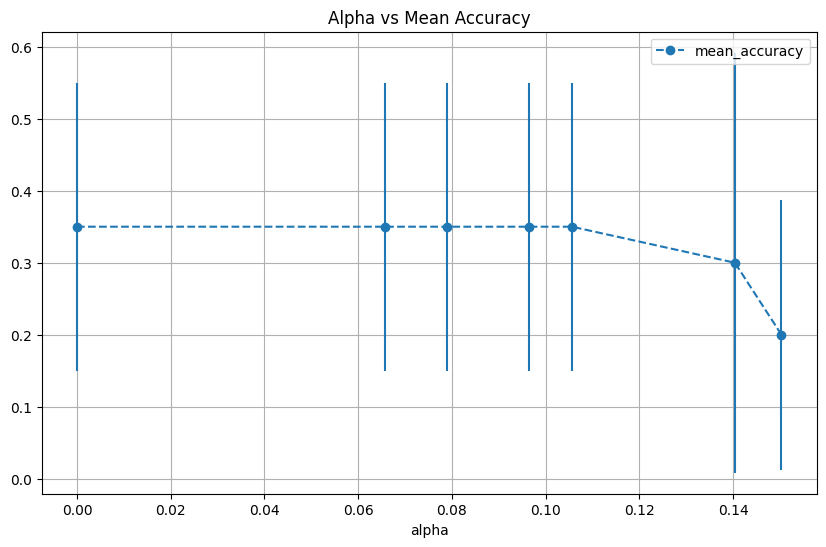

In [41]:
from sklearn.model_selection import KFold
import numpy as np

# Initialize lists and cross-validation
alpha_loop_values = []
kfold = KFold(n_splits=5, shuffle=True, random_state=42)  # Changed to KFold

# Loop through alphas
for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    scores = cross_val_score(clf_dt, X_train, y_train, cv=kfold)
    alpha_loop_values.append([ccp_alpha, np.mean(scores), np.std(scores)])

# Create and plot results
alpha_results = pd.DataFrame(alpha_loop_values, columns=["alpha", "mean_accuracy", "std"])
alpha_results.plot(x="alpha",
                  y="mean_accuracy",
                  yerr="std",
                  marker='o',
                  linestyle="--",
                  figsize=(10, 6))
plt.title('Alpha vs Mean Accuracy')
plt.grid(True)

In [42]:
# Filter and sort results
df1 = alpha_results[(alpha_results["alpha"] > 0) & (alpha_results["alpha"] < 0.04)]
sorted_df = df1.sort_values(by=['mean_accuracy'], ascending=False)
sorted_df

,alpha,mean_accuracy,std


In [43]:
# Train final model with best alpha
prunedtree_cv = DecisionTreeClassifier(ccp_alpha=0.021802, random_state=42).fit(X_train, y_train)

# Make predictions and get accuracy
y_pred = prunedtree_cv.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")

Model Accuracy: 0.8000


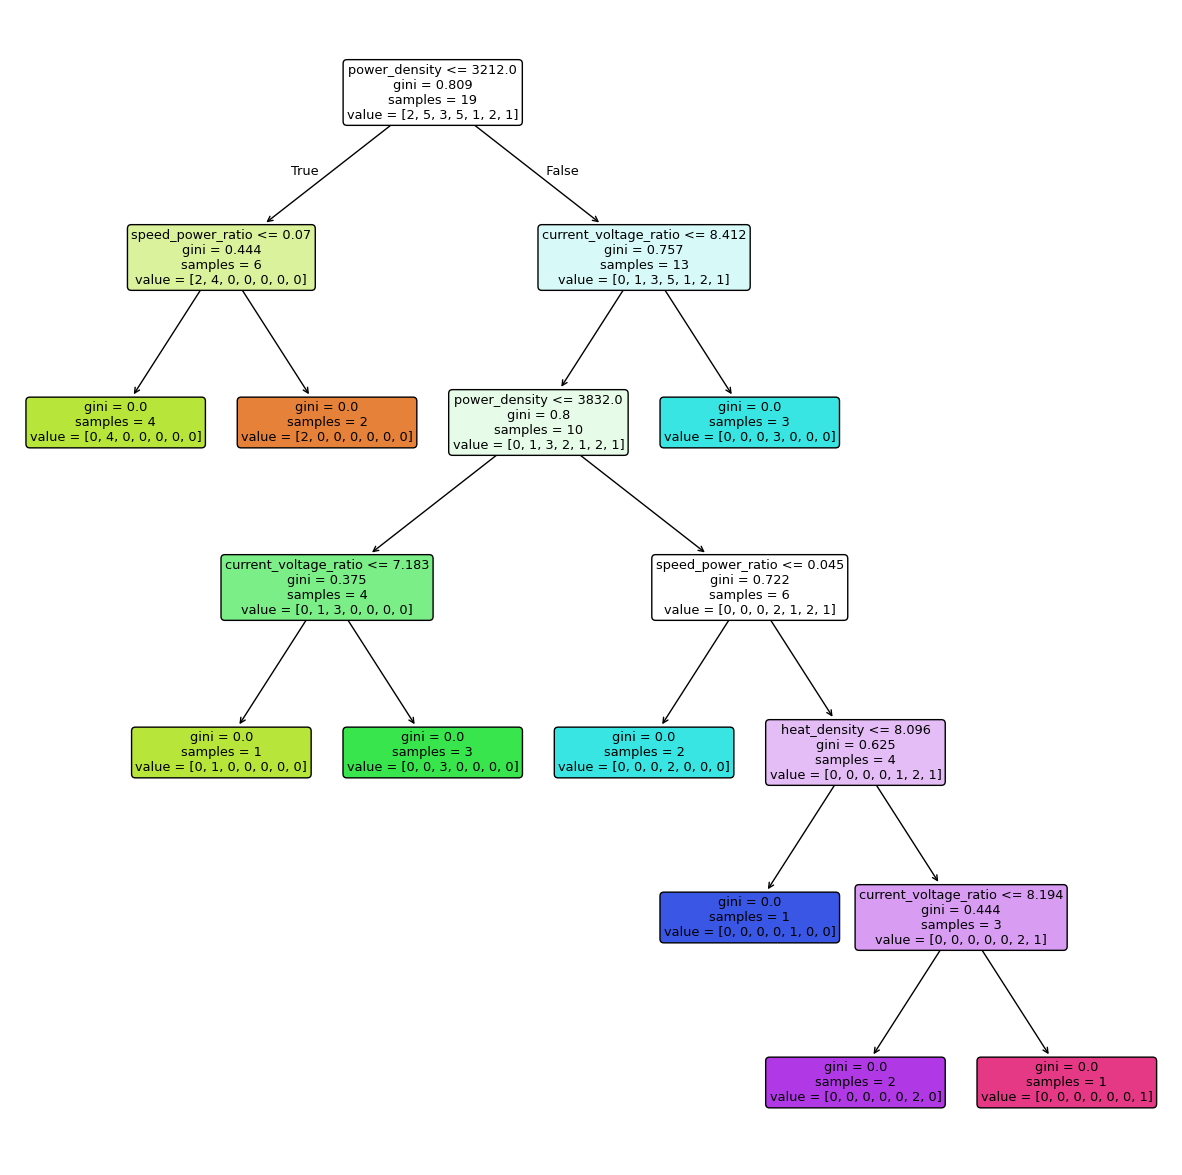

In [44]:
from sklearn.tree import plot_tree
plt.figure(figsize=(15,15))
plot_tree(prunedtree_cv,filled=True, rounded = True, feature_names= X_train.columns);

In [45]:
!pip install tabpfn # The TabPFN is a neural network designed for small size tabular classification problems.

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.6/156.6 kB 5.6 MB/s eta 0:00:00


In [46]:
from tabpfn import TabPFNClassifier

Error with XGB: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2 3 4 5 6], got [220 250 260 270 280 290 300]
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 19, number of used features: 0
[LightGBM] [Info] Start training from score -2.251292
[LightGBM] [Info] Start training from score -1.335001
[LightGBM] [Info] Start training from score -1.845827
[LightGBM] [Info] Start training from score -1.335001
[LightGBM] [Info] Start training from score -2.944439
[LightGBM] [Info] Start training from score -2.251292
[LightGBM] [Info] Start training from score -2.944439
[LightGBM] [Warning] Stopped training because there are no more leaves tha

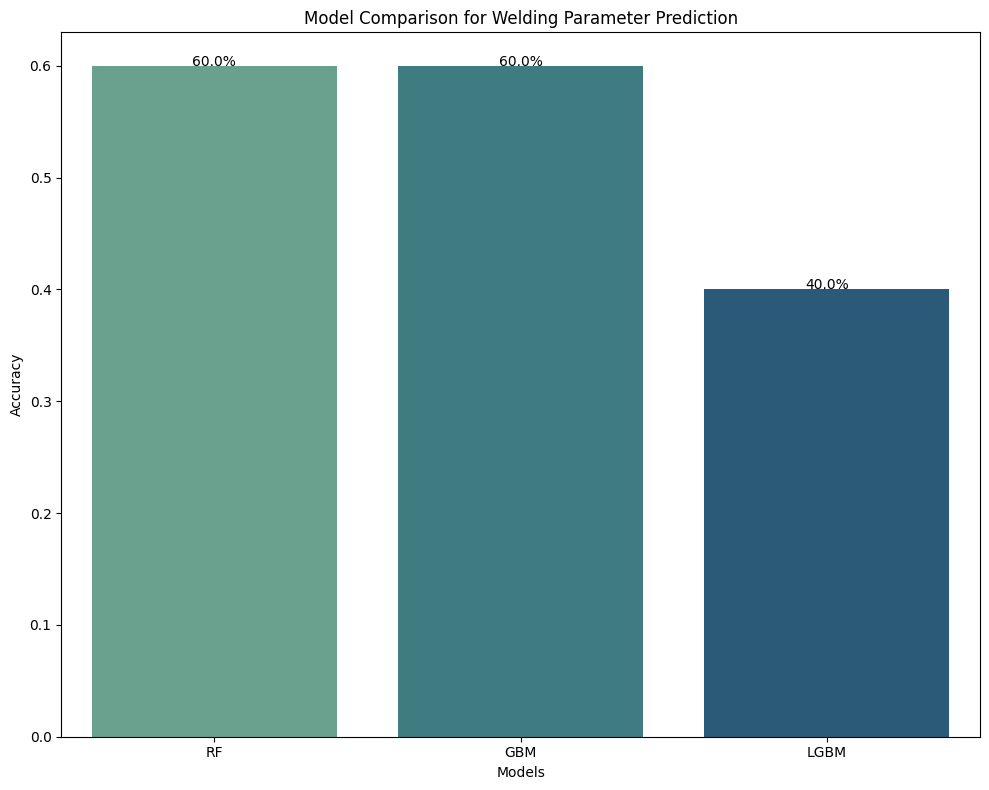

In [47]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
# Note: TabPFN might not be readily available, so we'll exclude it for now
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize models
models = []
models.append(('RF', RandomForestClassifier(random_state=42)))
models.append(('GBM', GradientBoostingClassifier(random_state=42)))
models.append(('XGB', XGBClassifier(random_state=42)))
models.append(('LGBM', LGBMClassifier(random_state=42)))
# Removed TabPFN as it might not be available

# Lists to store results
accT = []
names = []

# Train and evaluate each model
for name, model in models:
    try:
        clf = model.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        accT.append([name, accuracy_score(y_test, y_pred)])
    except Exception as e:
        print(f"Error with {name}: {str(e)}")

# Create results dataframe
results = pd.DataFrame(accT, columns=['model', 'Accuracy'])
groupedvalues = results.sort_values(by='Accuracy', ascending=False).reset_index()

# Plot results
plt.figure(figsize=(10, 8))
g = sns.barplot(x='model', y='Accuracy', data=groupedvalues, palette="crest")

# Add value labels on bars
for index, row in groupedvalues.iterrows():
    g.text(row.name, row.Accuracy,
           f"{round(row.Accuracy*100, 2)}%",
           color='black',
           ha="center")

plt.title('Model Comparison for Welding Parameter Prediction')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()

In [48]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

# Initialize and train Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

# Predictions
dt_pred = dt_model.predict(X_test)

# Detailed metrics
print("Decision Tree Classification Report:")
print(classification_report(y_test, dt_pred))

Decision Tree Classification Report:
              precision    recall  f1-score   support

         200       0.00      0.00      0.00         1
         220       0.50      1.00      0.67         1
         250       1.00      1.00      1.00         2
         260       1.00      1.00      1.00         1

    accuracy                           0.80         5
   macro avg       0.62      0.75      0.67         5
weighted avg       0.70      0.80      0.73         5

